# <u>Data Augmentation for Genetic Data</u>

## 1. Pre-processing

### 1.1 Packages

In [106]:
import pandas as pd

import numpy as np

from matplotlib import pyplot as plt

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.decomposition import PCA

from scipy.stats import chi2_contingency, spearmanr

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

### 1.2 Import Data

In [2]:
df = pd.read_csv(r"data\vcf_with_labels.csv")
samples = df['samples']
df = df.drop(columns = ['samples', 'score'])
columns = df.columns[1:]

### 1.3 Split train and test sets

In [3]:
y = df.label.values
X = df.drop(columns = 'label').values
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 999,
                                                    stratify = y)

print("Orginal dataset shape:", df.shape)
print("Features training dataset shape after split:", X_train.shape)
print("Features test dataset shape after split:", X_test.shape)
print("Target training dataset shape after split:", y_train.shape)
print("Target test dataset shape after split:", y_test.shape)

Orginal dataset shape: (1033, 1989)
Features training dataset shape after split: (723, 1988)
Features test dataset shape after split: (310, 1988)
Target training dataset shape after split: (723,)
Target test dataset shape after split: (310,)


## 2. EDA

### 2.1 Label distributions

In [4]:
label_counts = df['label'].value_counts()

Text(0.5, 0, 'Disease Presence (0: No, 1: Yes)')

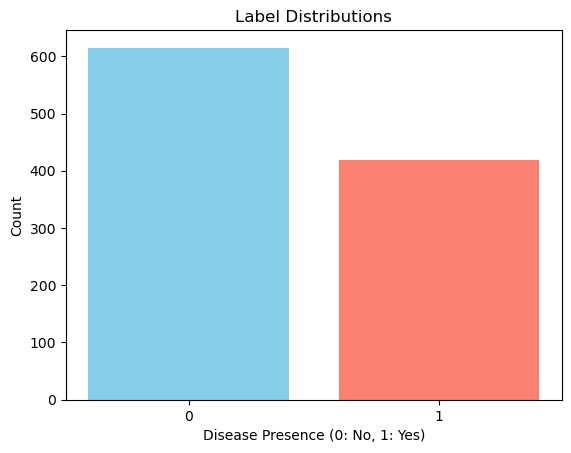

In [5]:
fig, ax = plt.subplots()

ax.bar(label_counts.index, label_counts, tick_label = label_counts.index,color=['skyblue', 'salmon'])
ax.set_title('Label Distributions')
ax.set_ylabel('Count')
ax.set_xlabel('Disease Presence (0: No, 1: Yes)')

### 2.2 Check for missing values

In [6]:
df.isnull().sum()

label                  0
chr22:16050408:T:C     0
chr22:16050612:C:G     0
chr22:16050678:C:T     0
chr22:16050984:C:G     0
                      ..
chr22:17796926:T:TA    0
chr22:17796951:A:G     0
chr22:17796971:C:A     0
chr22:17797010:G:A     0
chr22:17797041:T:C     0
Length: 1989, dtype: int64

In [7]:
df.isnull().sum().sum()

0

### 2.3 Mean Mutation Level

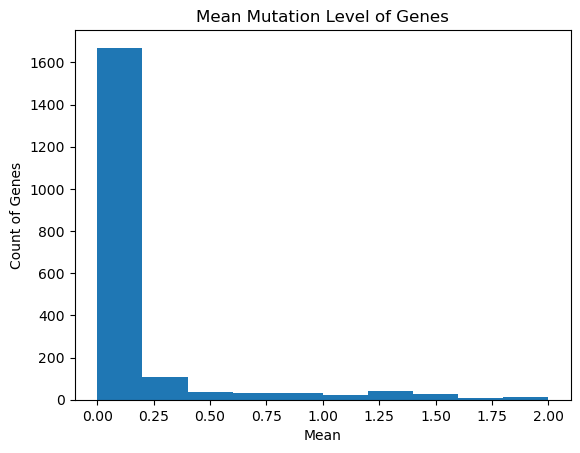

In [8]:
means = df.drop(columns = 'label').describe().iloc[1]

fig, ax = plt.subplots()

ax.hist(means)
ax.set_title('Mean Mutation Level of Genes')
ax.set_xlabel('Mean')
ax.set_ylabel('Count of Genes')

plt.show()

### 2.4 Correlation between genes and labels 

#### 2.4.1 Chi-squared test for independence 

In [9]:
ordinal_columns = df.drop(columns='label').columns

chisq_results = []

for col in ordinal_columns:
    # Create a contingency table
    contingency_table = pd.crosstab(df[col], df['label'])

    # Perform the chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    chisq_results.append({
        "Column": col,
        "Chi-Square Statistic": chi2,
        "P-value": p,
        "Degrees of Freedom": dof,
        "Expected Frequencies Table": expected
    })

In [10]:

count = 0
for result in chisq_results:
    if result['P-value'] < 0.05:
        count += 1
        
print(count)

154


#### 2.4.2 Speaman Rank Coefficient 

In [11]:
spearmanr_results = []

for col in ordinal_columns:
    # Calculate Spearman's rank correlation
    rho, p_value = spearmanr(df[col], df['label'])
    
    spearmanr_results.append({
        "Column": col,
        "Correlation": rho,
        "P-value": p_value
    })

C:\Users\fftwi\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [12]:
count = 0
for result in spearmanr_results:
    if result['P-value'] < 0.05:
        count += 1
        
print(count)

238


## 3. Data Augmentation Techniques

### 3.1 *mixup* 

In [14]:
def random_mixup(X, y, alpha=0.2, lower=0, upper=2):
    new_X = []
    new_y = []

    for i in range(len(X)/2):
        idx1, idx2 = np.random.choice(len(X), 2, replace=False)

        lam = np.random.beta(alpha, alpha)

        mixed_features = lam * X[idx1] + (1 - lam) * X[idx2]
        mixed_target = lam * y[idx1] + (1 - lam) * y[idx2]

        mixed_features = np.clip(mixed_features, lower, upper)

        new_X.append(mixed_features)
        new_y.append(mixed_target)

    mixed_X = np.array(new_X)
    mixed_y = np.array(new_y)

    return mixed_X, mixed_y

In [15]:
def ratio_mixup(x, y, alpha):
    """
    Returns mixed inputs and mixed labels using cross-label augmentation.
    """
    lam = alpha
    batch_size = x.shape[0]
    index = np.random.permutation(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_y = lam * y + (1 - lam) * y[index]
    
    mixed_y = (mixed_y >= 0.5).astype(int)
    
    return mixed_x, mixed_y

ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
mixup_data = {}

for ratio in ratios:
    X_mix, y_mix = ratio_mixup(X_train, y_train, ratio)
    mixup_data[f'mixup_{ratio}'] = {'X':X_mix, 'y':y_mix}

### 3.2 Noise Injection

In [30]:
np.random.seed(999)

def add_gaussian_noise(X, sigma=0.1):
    noise = np.random.normal(0, sigma, X.shape)
    return X + noise

def add_uniform_noise(X, intensity=0.1):
    noise = np.random.uniform(-intensity, intensity, X.shape)
    return X + noise

noise_levels = [0.01, 0.03, 0.05]
noise_data = {}

for level in noise_levels:
    X_gaussian = add_gaussian_noise(X_train, sigma=level)
    X_uniform = add_uniform_noise(X_train, intensity=level)
    noise_data[f'gaussian_{level}'] = X_gaussian
    noise_data[f'uniform_{level}'] = X_uniform

### 3.3 SMOTE 

In [17]:
smote = SMOTE(random_state=999)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

### 3.4 Adaptive Synthetic Sampling Technique (ADSYN) 

In [18]:
adasyn = ADASYN(random_state=999)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

### 3.5 Random under-sampling and over-sampling

In [19]:
rus = RandomUnderSampler(random_state=999)
X_under, y_under = rus.fit_resample(X_train, y_train)

ros = RandomOverSampler(random_state=999)
X_over, y_over = ros.fit_resample(X_train, y_train)

###  3.6 Principal Component Analysis (PCA)

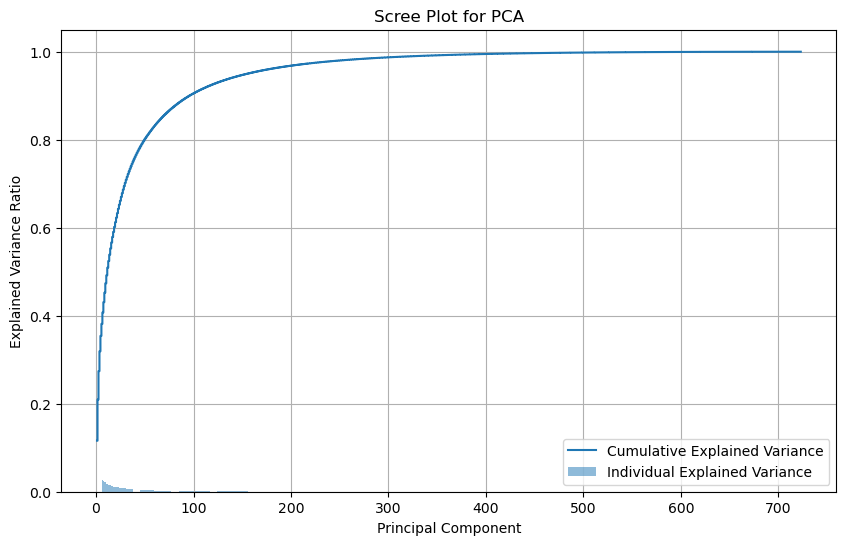

In [20]:
pca = PCA()
pca.fit(X_train)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Create a scree plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual Explained Variance')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot for PCA')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
pca_initial = PCA(n_components = 100)  # Taking top 100 components
X_pca_train = pca_initial.fit_transform(X_train)
X_pca_test = pca_initial.fit_transform(X_test)

## 4. Run Models 

### 4.1 Search for Good Experimental Hyperparameters to Serve as Baseline

In [21]:
rf_classifier = RandomForestClassifier(random_state = 999)

cv_method = RepeatedStratifiedKFold(n_splits=5,
                                    n_repeats=3,
                                    random_state=999)

scoring_metric = 'f1'

params_RF = {'criterion': ['entropy'],
             'n_estimators':[115],
             'max_depth': [50]}

In [22]:
gs_RF = GridSearchCV(estimator=rf_classifier,
                     param_grid=params_RF,
                     cv=cv_method,
                     verbose=1,
                     scoring=scoring_metric)

gs_RF.fit(X_train, y_train)

Fitting 15 folds for each of 1 candidates, totalling 15 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=RandomForestClassifier(random_state=999),
             param_grid={'criterion': ['entropy'], 'max_depth': [50],
                         'n_estimators': [115]},
             scoring='f1', verbose=1)

In [23]:
print('The best parameters for Random Forest Classifier are: ', gs_RF.best_params_)
print("The best score using area under the F1 metric is:", round(gs_RF.best_score_,3))

The best parameters for Random Forest Classifier are:  {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 115}
The best score using area under the F1 metric is: 0.407


In [24]:
base_params = {'criterion': 'entropy',
             'n_estimators': 115,
             'max_depth': 50}

### 4.2 Model Building

In [107]:
def train_runs(X_train, y_train, X_test, y_test, base_params, seeds):

    results = {}
    importances = [0] * len(X_train[0])
    
    for seed in seeds:

        rf_classifier = RandomForestClassifier( random_state=seed, **base_params)

        rf_classifier.fit(X_train, y_train)

        y_pred = rf_classifier.predict(X_test)
        
        results[str(seed)] = classification_report(y_test, y_pred, output_dict = True)
        
        y_scores = rf_classifier.predict_proba(X_test)[:, 1]
        
        auc_score = roc_auc_score(y_test, y_scores)
        
        results[str(seed)]['auc'] = auc_score
        
        importances += rf_classifier.feature_importances_
    
    importances = [x / len(seeds) for x in importances]
    
    return results, importances

In [108]:
seeds = np.arange(0, 30)

#### 4.2.1 Technique Runs 

In [105]:
base_results, base_importances = train_runs(X_train, y_train, X_test, y_test, base_params, seeds)
smote_results, smote_importances = train_runs(X_smote, y_smote, X_test, y_test, base_params, seeds)
adasyn_results, adasyn_importances = train_runs(X_adasyn, y_adasyn, X_test, y_test, base_params, seeds)
under_results, under_importances = train_runs(X_under, y_under, X_test, y_test, base_params, seeds)
over_results, over_importances = train_runs(X_over, y_over, X_test, y_test, base_params, seeds)
pca_results, pca_importances = train_runs(X_pca, y_train, X_pca_test, y_test, base_params, seeds)

NameError: name 'roc_auc_score' is not defined

#### 4.2.2 Mixup Runs

In [28]:
mixup_results = {}
mixup_importances = {}

for technique, _ in mixup_data.items():
    
    mixup_result, mixup_importance = train_runs(
        mixup_data[technique]['X'], 
        mixup_data[technique]['y'], 
        X_test, 
        y_test, 
        base_params, 
        seeds
    )
    
    mixup_results[technique] = mixup_result
    mixup_importances[technique] = mixup_importance

#### 4.2.3 Noise Injection Runs 

In [96]:
guassian_results = {}
guassian_importances = {}

uniform_results = {}
uniform_importances = {}

for technique, X_noise in noise_data.items():
    
    result, importance = train_runs(
        X_noise, 
        y_train, 
        X_test, 
        y_test, 
        base_params, 
        seeds
    )
    
    if 'guassian' in technique:
        guassian_results[technique] = result
        guassian_importances[technique] = importance

    if 'uniform' in technique:
        guassian_results[technique] = result
        guassian_importances[technique] = importance

C:\Users\fftwi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fftwi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fftwi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fftwi\anaconda3\lib\site-packages\sklearn\metr

## 5. Results 

### 5.1 Feature Stability 

In [68]:
importances = pd.DataFrame(data=base_importances, index=columns, columns=['baseline'])

#### 5.1.1 *mixup* Ratios 

In [69]:
mixup_importances_df = importances.copy(deep=True)

for ratio, importance in mixup_importances.items():
    mixup_importances_df[ratio] = importance

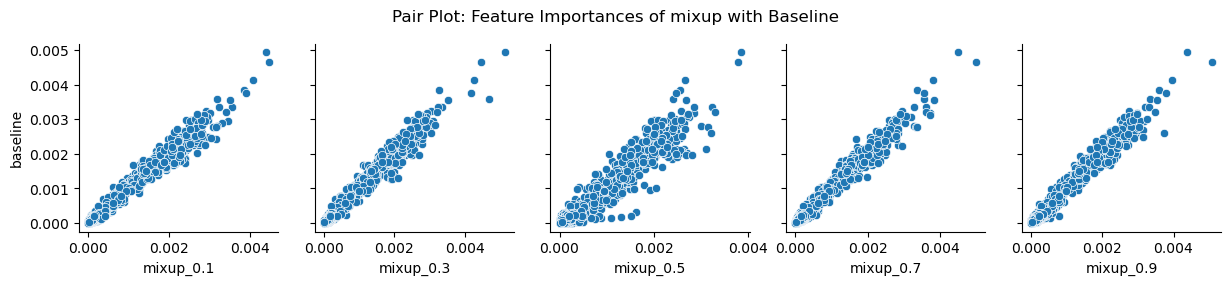

In [73]:
sns.pairplot(
    mixup_importances_df, 
    y_vars= ["baseline"], 
    x_vars = mixup_importances_df.columns.difference(["baseline"]), 
    kind = 'scatter'
)
plt.suptitle('Pair Plot: Feature Importances of mixup with Baseline', y=1.1)
plt.show()

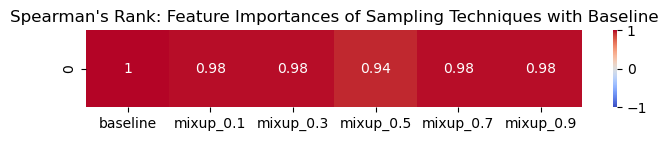

In [74]:
correlation_matrix = mixup_importances_df.corrwith(mixup_importances_df['baseline'],method='spearman')

plt.figure(figsize=(8, 1))
sns.heatmap(correlation_matrix.to_frame().T, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spearman's Rank: Feature Importances of Sampling Techniques with Baseline")
plt.show()

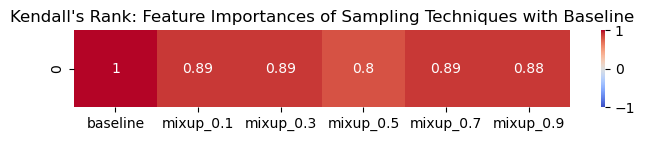

In [75]:
correlation_matrix = mixup_importances_df.corrwith(mixup_importances_df['baseline'],method='kendall')

plt.figure(figsize=(8, 1))
sns.heatmap(correlation_matrix.to_frame().T, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Kendall's Rank: Feature Importances of Sampling Techniques with Baseline")
plt.show()

####  5.1.2 Sampling Techniques

In [91]:
importances_sampling = importances.copy(deep=True)
importances_sampling['smote'] = smote_importances
importances_sampling['adasyn'] = adasyn_importances
importances_sampling['random_under_sampling'] = under_importances
importances_sampling['random_over_sampling'] = over_importances

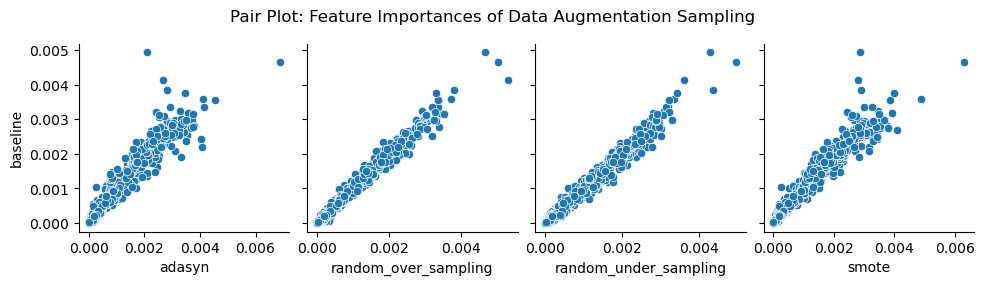

In [92]:
sns.pairplot(
    importances_sampling, 
    y_vars= ["baseline"], 
    x_vars = importances_sampling.columns.difference(["baseline"]), 
    kind = 'scatter'
)
plt.suptitle('Pair Plot: Feature Importances of Data Augmentation Sampling', y=1.1)
plt.show()

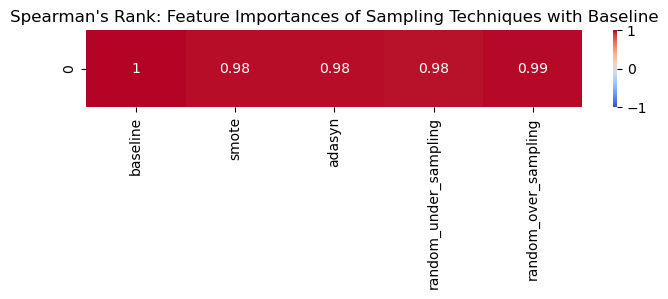

In [93]:
# Calculate the correlation matrix
correlation_matrix = importances_sampling.corrwith(importances_sampling['baseline'],method='spearman')

# Create a correlation heatmap
plt.figure(figsize=(8, 1))
sns.heatmap(correlation_matrix.to_frame().T, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spearman's Rank: Feature Importances of Sampling Techniques with Baseline")
plt.show()

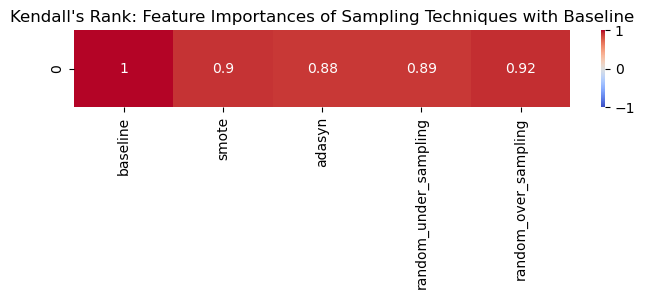

In [94]:
correlation_matrix = importances_sampling.corrwith(importances_sampling['baseline'],method='kendall')

plt.figure(figsize=(8, 1))
sns.heatmap(correlation_matrix.to_frame().T, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Kendall's Rank: Feature Importances of Sampling Techniques with Baseline")
plt.show()

### 5.2 Scores 

#### 5.2.1 *mixup* Technique Scores 

In [84]:
category = []
values = []

for _, result in base_results.items():
    values.append(result['weighted avg']['f1-score'])
    category.append('base')
    
for technique, results in mixup_results.items():
        for _, result in results.items():
            values.append(result['weighted avg']['f1-score'])
            category.append(technique)

In [85]:
mixup_results_df = pd.DataFrame({
    'Category': category,
    'Values': values
})

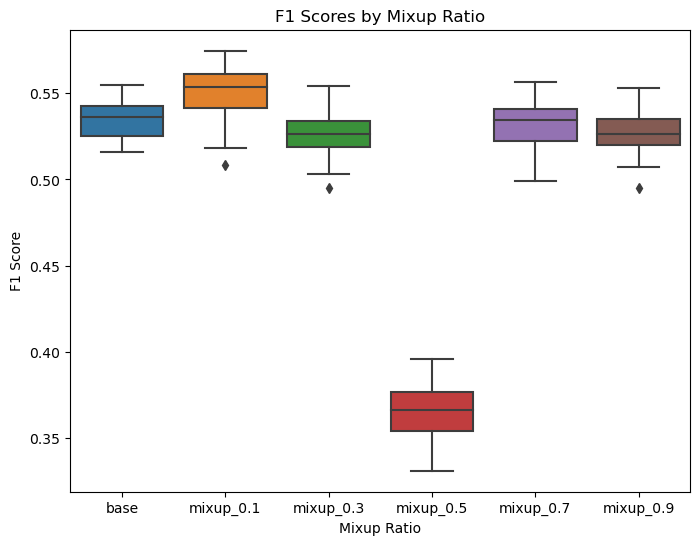

In [86]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Category', y='Values', data=mixup_results_df)

plt.title("F1 Scores by Mixup Ratio")
plt.ylabel("F1 Score")
plt.xlabel("Mixup Ratio")

plt.show()

#### 5.2.2 Sampling Technique Scores 

In [87]:
sampling_results = [
    ('base',base_results),
    ('smote',smote_results),
    ('adasyn',adasyn_results),
    ('random_under_sampling',under_results),
    ('random_over_sampling',over_results),
    ('pca',pca_results)
]

category = []
values = []

for results in sampling_results:
    for _, result in results[1].items():
        values.append(result['weighted avg']['f1-score'])
        category.append(results[0])

In [88]:
sampling_results_df = pd.DataFrame({
    'Category': category,
    'Values': values
})

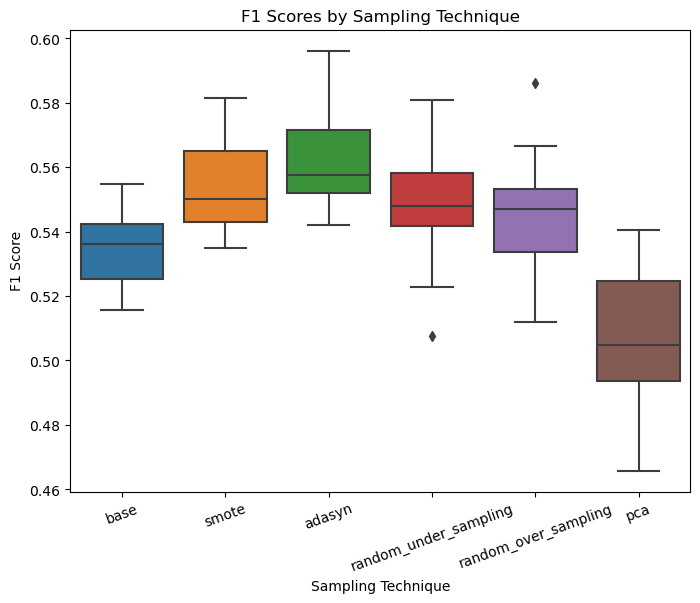

In [89]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Category', y='Values', data=sampling_results_df)

plt.title("F1 Scores by Sampling Technique")
plt.ylabel("F1 Score")
plt.xlabel("Sampling Technique")
plt.xticks(rotation=20)

plt.show()